# Customizing Colorbars

- Plot legends identify discrete labels of discrete points.
- Colorbars identify continuous labels based on the color of points, lines, or regions. In Matplotlib, a colorbar is a separate axes that can provide a key for the meaning of colors in a plot.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('classic')

In [2]:
%matplotlib inline
import numpy as np

- A basic colorbar can be created with the ``plt.colorbar`` function:

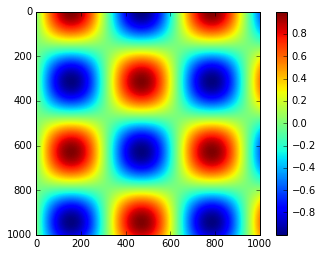

In [3]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

plt.imshow(I)
plt.colorbar();

- The colormap can be specified using ``cmap``:

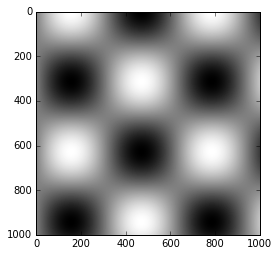

In [5]:
plt.imshow(I, cmap='gray')

- Available colormaps are in the ``plt.cm`` namespace; using IPython's tab-completion will give you a full list of built-in possibilities:
```
plt.cm.<TAB>
```
- Deciding which cmap to use is a subtle problem.

### Choosing the Colormap

- Be aware of three different categories of colormaps:
    - *Sequential colormaps*: (one continuous sequence of colors (e.g., ``binary`` or ``viridis``)).
    - *Divergent colormaps*: (two distinct colors, which show positive and negative deviations from a mean (e.g., ``RdBu`` or ``PuOr``)).
    - *Qualitative colormaps*: (A mix of colors with no particular sequence (e.g., ``rainbow`` or ``jet``)).


- The ``jet`` colormap was the default in Matplotlib prior to v2.0, is an example of a qualitative colormap.
Its status as the default was quite unfortunate, because qualitative maps are often a poor choice for representing quantitative data.
Among the problems is the fact that qualitative maps usually do not display any uniform progression in brightness as the scale increases.

We can see this by converting the ``jet`` colorbar into black and white:

In [6]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

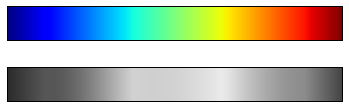

In [7]:
view_colormap('jet')

- __Notice the bright stripes in the grayscale image.__ Even in full color, this uneven brightness means that the eye will be drawn to certain portions of the color range, which will potentially emphasize unimportant parts of the dataset.
- It's better to use a colormap such as ``viridis`` (the default as of Matplotlib 2.0), which is specifically constructed to have an even brightness variation across the range. It works with human color perception & translates well to grayscale:

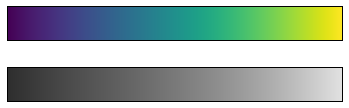

In [8]:
view_colormap('viridis')

- If you favor rainbow schemes, another good option for continuous data is the ``cubehelix`` colormap:

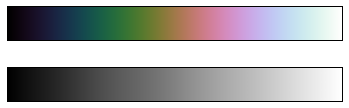

In [9]:
view_colormap('cubehelix')

- For other situations, such as showing positive and negative deviations from some mean, dual-color colorbars such as ``RdBu`` (*Red-Blue*) can be useful. However, positive-negative information will be lost when translated to grayscale!

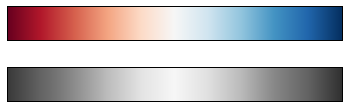

In [10]:
view_colormap('RdBu')

### Color limits and extensions

- Matplotlib allows for a large range of colorbar customization.
- A colorbar is simply an instance of ``plt.Axes``, so all of the axes and tick formatting tricks we've learned are applicable.
- We can narrow the color limits and indicate out-of-bounds values with a triangular arrow at the top and bottom by setting the ``extend`` property.
- This might come in handy, for example, if displaying an image that is subject to noise:

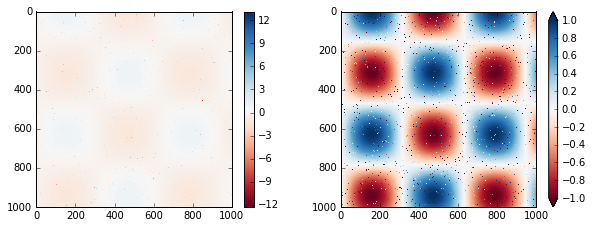

In [11]:
# make noise in 1% of the image pixels
speckles = (np.random.random(I.shape) < 0.01)
I[speckles] = np.random.normal(0, 3, np.count_nonzero(speckles))

plt.figure(figsize=(10, 3.5))

plt.subplot(1, 2, 1)
plt.imshow(I, cmap='RdBu')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(I, cmap='RdBu')
plt.colorbar(extend='both')
plt.clim(-1, 1);

- In the left panel, the default color limits respond to the noisy pixels, and the range of the noise completely washes-out the pattern we are interested in.
- In the right panel, we manually set the color limits & add extensions to indicate values which are above or below those limits.
- The result is a much more useful visualization of our data.

### Discrete Color Bars

- Colormaps are by default continuous, but sometimes you'd like to represent discrete values.
- Use the ``plt.cm.get_cmap()`` function, and pass the name of a colormap along with the number of desired bins:

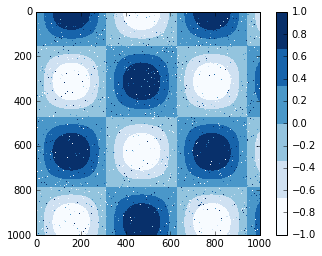

In [12]:
plt.imshow(I, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar()
plt.clim(-1, 1);

- The discrete version of a colormap can be used just like any other colormap.

### Example: Handwritten Digits

- This dataset consists of nearly 2,000 $8 \times 8$ thumbnails showing various hand-written digits.
- Start by downloading the digits data and visualizing several of the example images with ``plt.imshow()``:

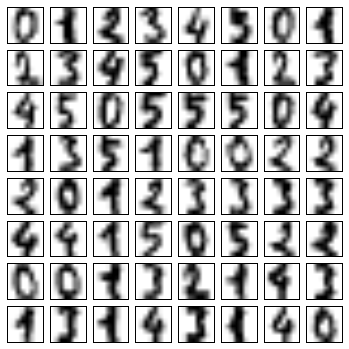

In [12]:
# load images of the digits 0 through 5 and visualize several of them
from sklearn.datasets import load_digits
digits = load_digits(n_class=6)

fig, ax = plt.subplots(8, 8, figsize=(6, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(digits.images[i], cmap='binary')
    axi.set(xticks=[], yticks=[])

- Each digit is defined by the hue of its 64 pixels, so we can consider each digit to be a point lying in 64-dimensional space: each dimension represents the brightness of one pixel.
- But visualizing high-dimensional relationships can be extremely difficult.
- One way to approach this is to use a *dimensionality reduction* technique such as manifold learning to reduce the dimensionality of the data while maintaining the relationships of interest. Dimensionality reduction is an example of unsupervised machine learning, and we will discuss it in more detail in [What Is Machine Learning?](05.01-What-Is-Machine-Learning.ipynb).
- Let's build a 2D manifold learning projection of the digits data.

In [13]:
# project the digits into 2 dimensions using IsoMap
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
projection = iso.fit_transform(digits.data)

- Use a discrete colormap to view the results, setting the ``ticks`` and ``clim`` to improve the aesthetics of the resulting colorbar:

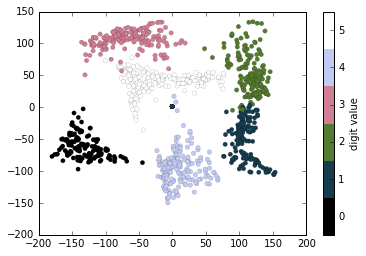

In [14]:
# plot the results
plt.scatter(projection[:, 0], projection[:, 1], lw=0.1,
            c=digits.target, cmap=plt.cm.get_cmap('cubehelix', 6))
plt.colorbar(ticks=range(6), label='digit value')
plt.clim(-0.5, 5.5)

- Interesting dataset obserations:
    - The ranges of 5 and 3 nearly overlap in this projection, indicating that some hand written fives and threes are difficult to distinguish, and therefore more likely to be confused by an automated classification algorithm.
    - Other values like 0 & 1 are more distantly separated, and therefore much less likely to be confused.
    - This agrees with intuition, because 5 and 3 look much more similar than do 0 and 1.